# Facial Expressions Classification

[Link](http://www.consortium.ri.cmu.edu/ckagree/) to the Cohn-Kanade (CK+) database.

<a id='index'></a>
## Index

- [Data preprocessing](#index)
- [Feature extraction](#feature_extraction)
- [Classifier development](#classifier_development)
- [Results](#results)

## Data preprocessing

In [1]:
%load_ext autoreload

In [6]:
from data_processing import sort_CK_data

# Labels for the CK+ database
FACIAL_EXPRESSIONS_LABELS = { 0  : 'neutral',
                              1  : 'anger',
                              2  : 'contempt',
                              3  : 'disgust',
                              4  : 'fear',
                              5  : 'happy',
                              6  : 'sadness',
                              7  : 'surprise'}

images_root = 'data/CK+/images'
labels_root = 'data/CK+/labels'
sort_to_root = 'data/CK+/sorted' # dir to sort the images into different folders based on the facial expression

sort_CK_data(images_root,
             labels_root,
             FACIAL_EXPRESSIONS_LABELS,
             sort_to_root)

<a id='feature_extraction'></a>
## Feature extraction

[back to index](#index)

In [15]:
%autoreload
from data_processing import get_all_data

# Set of selected features to work with, i.e. how many facial epxressions will be classified
selected_labels = {'neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'}

X, y, img_paths = get_all_data(sort_to_root, selected_labels)

In [52]:
import numpy as np

TEST_SIZE = 0.33

X_train, y_train, X_test, y_test, test_images = [], [], [], [], []

for i in range(len(img_paths)):
    if np.random.random() <= TEST_SIZE:
        X_test.append(X[i])
        y_test.append(y[i])
        test_images.append(img_paths[i])
    else:
        X_train.append(X[i])
        y_train.append(y[i])

print("Number of training examples: ", len(X_train))
print("Number of test examples: ", len(X_test))
print("Number of features: ", len(X[0]))
print("Number of training classes: ", np.unique(y_train))
print("Number of test classes: ", np.unique(y_test))

Number of training examples:  437
Number of test examples:  217
Number of features:  136
Number of training classes:  ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sadness' 'surprise']
Number of test classes:  ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sadness' 'surprise']


<a id='classifier_development'></a>
## Classifier development

[back to index](#index)

In [24]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('classifier', SVC(cache_size=1000, probability=True))])

params = [{'classifier__kernel' : ['rbf', 'sigmoid'],
           'classifier__C'      : [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 
                                   1,
                                   1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4],
           'classifier__gamma'  : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}]

grid_search = GridSearchCV(pipeline, params, cv=10, n_jobs=3, scoring='f1_micro')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=3,
       param_grid=[{'classifier__C': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0], 'classifier__gamma': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1], 'classifier__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_micro', verbose=0)

<a id='results'></a>
## Results

[back to index](#index)

Best params: 

 {'classifier__C': 10.0, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}

Best score from Grid Search: 85.31%

Cross-Validation (CV) results:

Min score: 80.43% 				<- worst case
Max score: 92.68% 				<- best case
Mean score: 85.38% +- 7.48% (95% conf.) 	<- expected performance

95% conf. meaning: 95/100 times the test score will be in range 77.91-92.86%

Test score: 87.07%

             precision    recall  f1-score   support

      anger       0.82      0.50      0.62        18
   contempt       0.00      0.00      0.00         3
    disgust       0.79      0.92      0.85        25
       fear       1.00      0.78      0.88         9
      happy       0.96      0.96      0.96        24
    neutral       0.83      0.98      0.90       106
    sadness       1.00      0.09      0.17        11
   surprise       1.00      0.97      0.99        36

avg / total       0.87      0.87      0.85       232



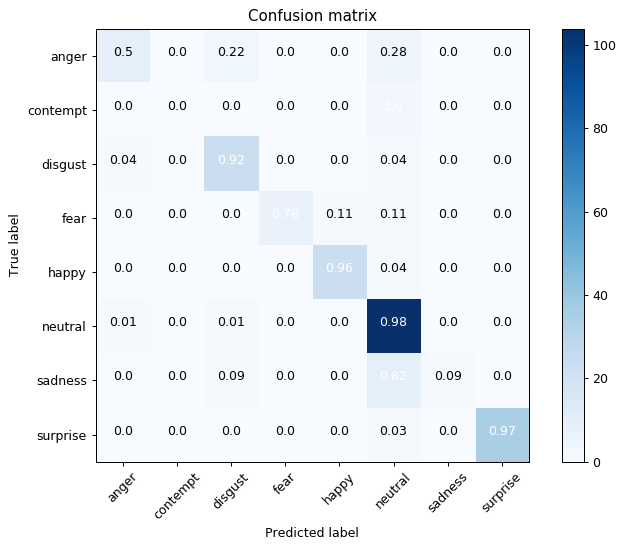

In [30]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import cross_val_score

%autoreload
from utils import k_fold_validation, plot_confusion_matrix

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print("Best params: \n\n", grid_search.best_params_)
print("\nBest score from Grid Search: %.2f%%" % (grid_search.best_score_ * 100))

cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=10)
print("\nCross-Validation (CV) results:\n")
print("Min score: %.2f%% \t\t\t\t<- worst case" % (cv_scores.min() * 100))
print("Max score: %.2f%% \t\t\t\t<- best case" % (cv_scores.max() * 100))
print("Mean score: %.2f%% +- %.2f%% (95%% conf.) \t<- expected performance" % 
      (cv_scores.mean() * 100, cv_scores.std() * 200))

print("\n95%% conf. meaning: 95/100 times the test score will be in range %.2f-%.2f%%" %
     (((cv_scores.mean() - 2 * cv_scores.std()) * 100), ((cv_scores.mean() + 2 * cv_scores.std()) * 100)))

print("\nTest score: %.2f%%\n" % (grid_search.best_estimator_.score(X_test, y_test) * 100))

print(metrics.classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

plot_confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test), title="Confusion matrix")

[back to index](#index)

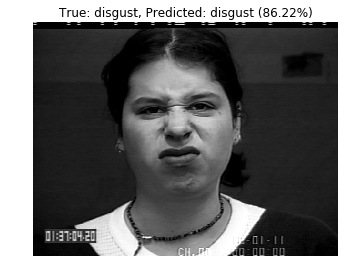

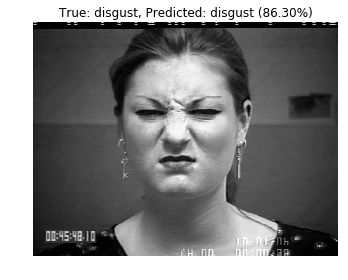

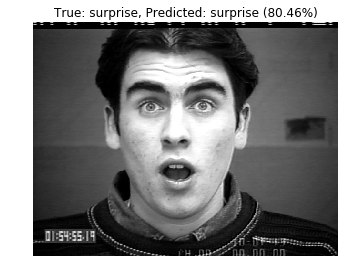

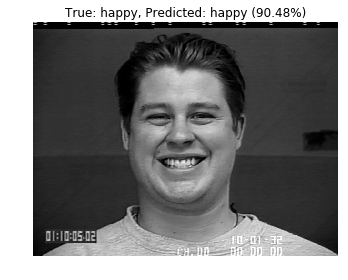

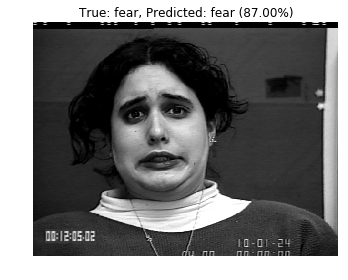

In [54]:
import cv2
import matplotlib.pyplot as plt

# Pick random subjects
num_to_pick = 8
subjects = ['S52', 'S55', 'S74', 'S106', 'S111', 'S113', 'S121', 'S124', 'S125', 'S130', 'S132']
picked = np.random.choice(subjects, num_to_pick, replace=False)

y_test_hat = grid_search.best_estimator_.predict(X_test)
probs = grid_search.best_estimator_.predict_proba(X_test)

for subj in picked:
    found = False
    for idx, path in enumerate(test_images):
        if subj in path and y_test[idx] not in {'neutral'}: 
            found = True
            break
            
    if not found:
        continue
            
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # Convert to RGB for matplotlib
    
    fig = plt.figure()

    plt.imshow(img)
    plt.axis('off')
    plt.title("True: %s, Predicted: %s (%.2f%%)" % (y_test[idx], y_test_hat[idx], max(probs[idx]) * 100))    
    plt.tight_layout()
    plt.show()    

In [51]:
import os
from sklearn.externals import joblib

# Pickle the best classifier
save_to_dir = 'best_classifier'
if not os.path.exists(save_to_dir):
    os.mkdir(save_to_dir)
joblib.dump(grid_search.best_estimator_, '%s/std_scaler_svm_pipeline.pkl' % save_to_dir, compress=1)

['best_classifier/std_scaler_svm_pipeline.pkl']